In [11]:
import os

import matplotlib.pyplot as plt
import numpy as np
import open3d as o3d
import pandas as pd

from pypcd4 import PointCloud
from scipy.spatial.transform import Rotation
from typing import List, Tuple

import tools.ICP as icp

# Load the pcd from the map.pcd file

In [12]:
def pcd_from_path(file_path: str) -> np.ndarray:
    """
    Loads point clouds from PCD files using the PointCloud library (assumed to be open3d or similar).

    Parameters:
        file_path (str): Path to a .pcd file.

    Returns:
        np.ndarray: Numpy array representing the point cloud, shape [n_points, m_channels].
    
    Raises:
        ValueError: If the file format is not 'pcd'.
        FileNotFoundError: If the file does not exist.
    """
    if not file_path.endswith(".pcd"):
        raise ValueError('Only ".pcd" format is accepted.')
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    pc = PointCloud.from_path(file_path)
    return pc.numpy()

# Downsample to voxels

In [13]:
def downsample_voxel(map_array: np.ndarray, voxel_size: float):
    """
    Downsamples a pointcloud using a voxel grid, and provides voxel configurations.

    Args:
    - map_pcd_arr (np.ndarray): Input point cloud as an Nx3 numpy array.
    - voxel_size (float): Desired voxel size for downsampling.

    Returns:
    - Tuple[np.ndarray, dict]: Downsampled point cloud as an Nx3 numpy array,
                               and a dictionary with voxel configuration details.
    """
    # Convert np array to open3D pointcloud
    map_pcd = o3d.geometry.PointCloud()
    map_pcd.points = o3d.utility.Vector3dVector(map_array)
    
    # Use open3D voxelisation utility with desired voxel_size
    voxel_grid = o3d.geometry.VoxelGrid.create_from_point_cloud(map_pcd, voxel_size)
    
    # Get coordinates of the voxels that are points of the downsampled grid
    indices = np.array([voxel.grid_index for voxel in voxel_grid.get_voxels()], dtype=float) * voxel_size

    # Calculate voxel configuration details
    max_bound = voxel_grid.get_max_bound()
    min_bound = voxel_grid.get_min_bound()
    voxel_config = {
        'voxel_bounds': {'min': 0, 'max': indices.max(axis=0)},
        'real_bounds': {'min': min_bound, 'max': max_bound}
    }

    # Adjust indices to represent real-world coordinates (center of each voxel)
    indices += min_bound + voxel_size / 2

    return indices, voxel_config


# Plot 2D

In [14]:
def plot_pcd(ax: plt.Axes, points: np.ndarray, **kwargs):
    """
    Plots point cloud data on a given matplotlib axis.

    Parameters:
        ax (matplotlib.axes.Axes): The axes on which to plot the point cloud.
        points (np.ndarray): The point cloud data, expected shape [n_points, at least 2].
        **kwargs: Additional keyword arguments passed to matplotlib scatter plot.

    Raises:
        ValueError: If 'points' does not have the correct dimensions.
    """
    if points.ndim < 2 or points.shape[1] < 2:
        raise ValueError("The 'points' array must have at least two dimensions [n_points, at least 2].")

    return ax.scatter(points[:, 0], points[:, 1], **kwargs)

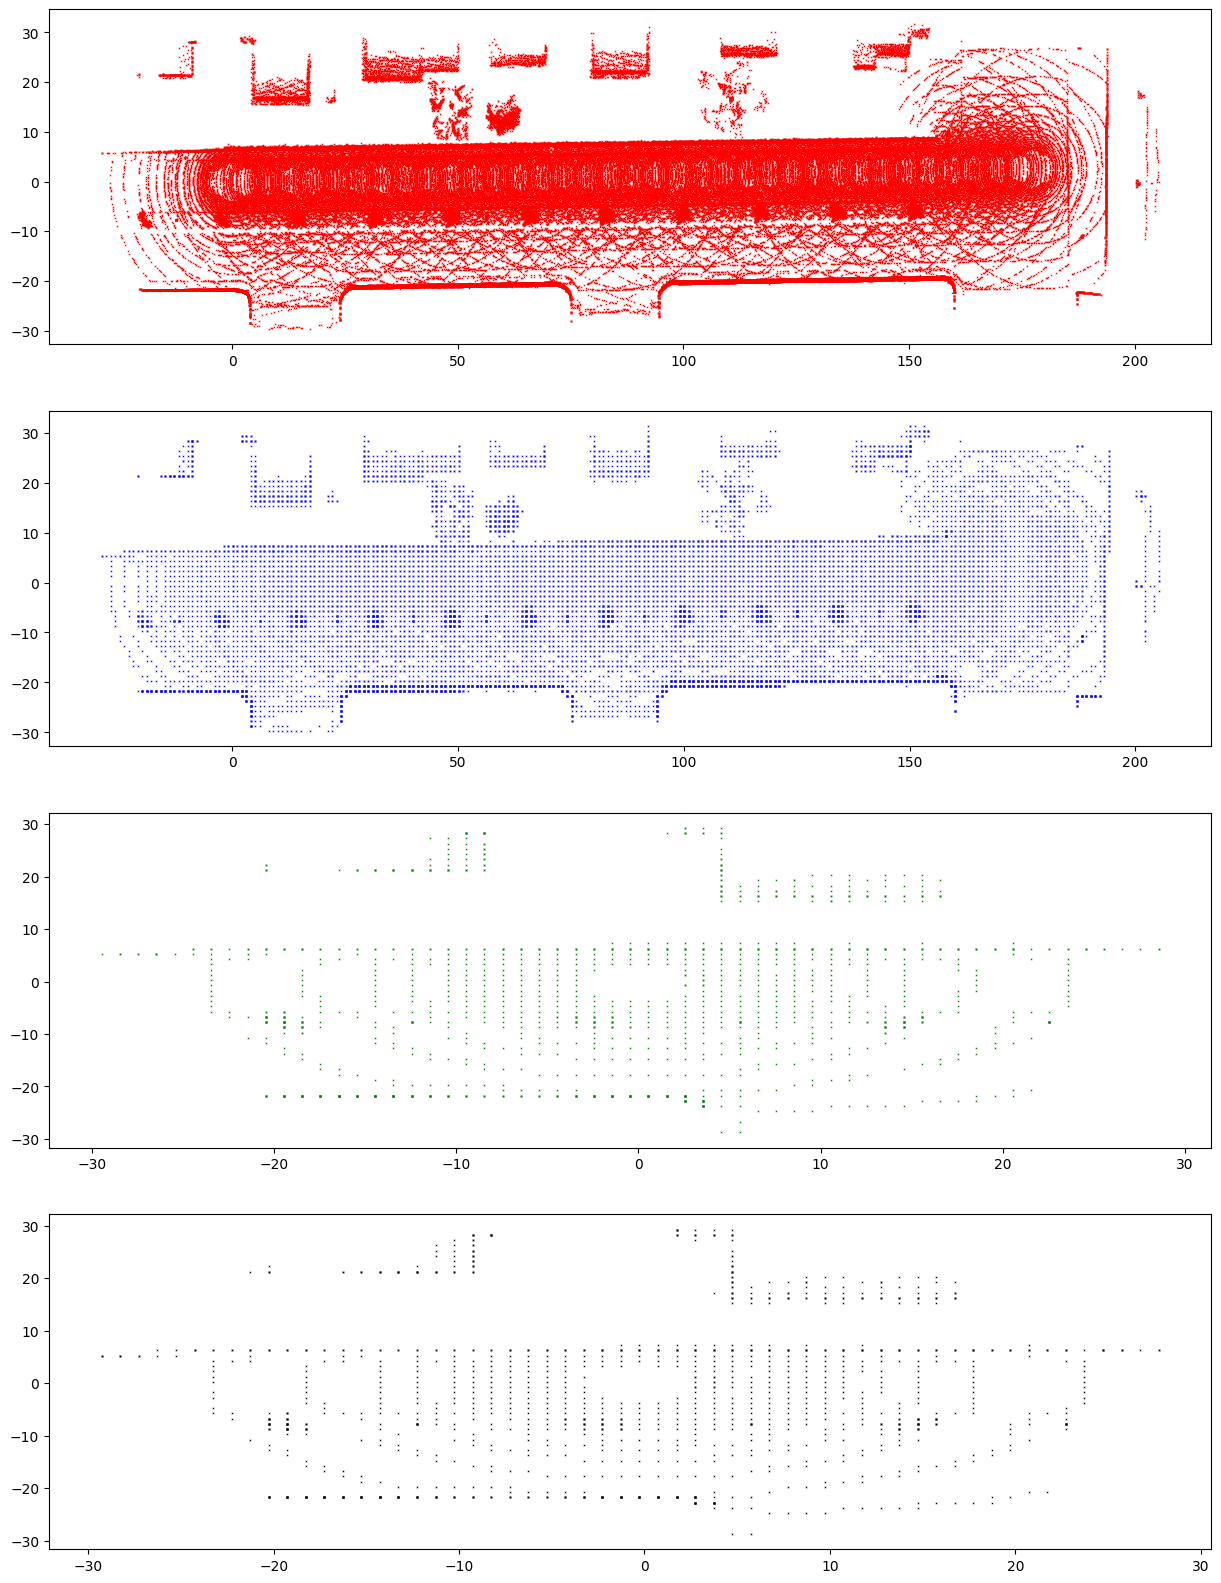

In [25]:
map_array = pcd_from_path("../dataset/map.pcd")

fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(15, 20))
voxel_map, voxel_config_show = downsample_voxel(map_array, voxel_size=1)

voxel_frames=np.empty(1013, dtype=object)
voxel_config_frames=np.empty(1013, dtype=object)

for frame in range (5,10): #range(0, 1013):
    current_frame_array = pcd_from_path("../dataset/frames/frame_"+str(frame)+".pcd")
    voxel_frames[frame], voxel_config_frames[frame] = downsample_voxel(current_frame_array, voxel_size=1)

plot_pcd(ax1, map_array, color="red", label="Target", marker='x',s=.10)
plot_pcd(ax2, voxel_map, color="blue", label="Target", marker='x',s=.10)

plot_pcd(ax3, voxel_frames[6], color="green", label="Target", marker='x',s=.10)
plot_pcd(ax4, voxel_frames[7], color="black", label="Target", marker='x',s=.10)

